# INM702 Coursework Task 2
### Aaron Mir (Student Number: 160001207)

The second task is about classifying handwritten digits. We will use the MNIST dataset for training and testing. The point of this task is to develop a multi-layer neural network for classification using mostly Numpy:


    • Implement sigmoid and relu layers (with forward and backward pass) hidden layers

    • Implement a softmax output classification layer 
    
    • Implement a fully parameterizable neural network (number and types of layers, number of units)

    • Implement an optimizer(e.g. SGD or Adam)and a stopping criterion of your choosing

    • Train your Neural Network using backpropagation

    • Keep track of your statistics i.e. different means/variance

Evaluate different neural network architectures and compare your different results. e.g. fully relu vs fully sigmoid, number of layers etc.

You can also compare withthe results presented in http://yann.lecun.com/exdb/mnist/

In [56]:
import numpy as np
import matplotlib.pyplot as plt
import torch
from torchvision import datasets, transforms
np.set_printoptions(linewidth=200)
np.random.seed(1)

In [57]:
def MNIST_load():
    train_set = datasets.MNIST(root='./data', train=True, download=True, transform=None)
    test_set = datasets.MNIST(root='./data', train=False, download=True, transform=None)
    X_train = train_set.data.numpy()                                                    # Transforms tensors to np array
    y_train = train_set.targets.numpy()
    X_test = test_set.data.numpy()
    y_test = test_set.targets.numpy()
    return train_set, test_set, X_train, y_train, X_test, y_test

In [58]:
train_set, test_set, X_train_raw, y_train_raw, X_test_raw, y_test_raw = MNIST_load()

In [59]:
def MNIST_preprocessing(MNIST_train, MNIST_train_label, MNIST_test, MNIST_test_label): # normalise, center, standardise, flatten and shuffle
    print('Data type of MNIST_train: %s' % MNIST_train.dtype)
    #print('Min: %.3f, Max: %.3f' % (MNIST_train.min(), MNIST_train.max()))
    MNIST_train = MNIST_train.astype('float32')
    MNIST_test = MNIST_test.astype('float32')
    print('New data type of MNIST_train: %s' % MNIST_train.dtype)
    MNIST_train /= 255.0
    MNIST_test /= 255.0
    print('New Min: %.3f, New Max: %.3f' % (MNIST_train.min(), MNIST_train.max()))
    print('Data has been normalised')
    
    mean_train = MNIST_train.mean()
    mean_test = MNIST_train.mean()
    print('Mean of training set: %.3f' % mean_train)
    #print('Min: %.3f, Max: %.3f' % (MNIST_train.min(), MNIST_train.max()))
    MNIST_train = MNIST_train - mean_train
    MNIST_test = MNIST_test - mean_test
    mean_train = MNIST_train.mean()
    mean_test = MNIST_test.mean()
    print('New mean of training set: %.3f' % mean_train)
    #print('New Min: %.3f, New Max: %.3f' % (MNIST_train.min(), MNIST_train.max()))
    print('Data has been centered')

    mean_train, std_train = MNIST_train.mean(), MNIST_train.std()
    mean_test, std_test = MNIST_test.mean(), MNIST_test.std()
    print('Standard deviation of training set: %.3f' % std_train)
    MNIST_train = (MNIST_train - mean_train) / std_train
    MNIST_test = (MNIST_test - mean_test) / std_test
    # confirm it had the desired effect
    mean_train, std_train = MNIST_train.mean(), MNIST_train.std()
    mean_test, std_test = MNIST_test.mean(), MNIST_test.std()
    print('New mean of training and testing set: %.3f, New standard deviation of training and testing set: %.3f' % (mean_train, std_train))
    print('Data has been standardised')

    MNIST_train = MNIST_train.reshape(MNIST_train.shape[0], -1)
    MNIST_test = MNIST_test.reshape(MNIST_test.shape[0], -1)
    MNIST_train_keys = np.array(range(MNIST_train.shape[0]))
    MNIST_test_keys = np.array(range(MNIST_test.shape[0]))
    np.random.shuffle(MNIST_train_keys)
    np.random.shuffle(MNIST_test_keys)
    MNIST_train = MNIST_train[MNIST_train_keys]
    MNIST_train_label = MNIST_train_label[MNIST_train_keys]
    MNIST_test = MNIST_test[MNIST_test_keys]
    MNIST_test_label = MNIST_test_label[MNIST_test_keys]
    print("Data has been flattened and shuffled")
    return MNIST_train, MNIST_train_label, MNIST_test, MNIST_test_label

In [60]:
X_train, y_train, X_test, y_test = MNIST_preprocessing(X_train_raw, y_train_raw, X_test_raw, y_test_raw)

Data type of MNIST_train: uint8
New data type of MNIST_train: float32
New Min: 0.000, New Max: 1.000
Data has been normalised
Mean of training set: 0.131
New mean of training set: -0.000
Data has been centered
Standard deviation of training set: 0.308
New mean of training and testing set: 0.000, New standard deviation of training and testing set: 1.000
Data has been standardised
Data has been flattened and shuffled


In [61]:
print(X_train.shape, X_test.shape) # 6000 per classification for X_train and 1000 for X_test - balanced - 784 features for each image

(60000, 784) (10000, 784)


In [62]:
y_train[0]

3

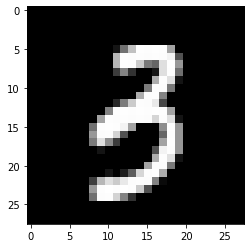

In [63]:
plt.imshow((X_train[0].reshape(28, 28)), cmap='gray');

In [64]:
class FC_Layer:     
    '''A class to represent a fully-connected layer with random initialisation of weights.'''
    def __init__(self, num_inputs, num_neurons):
        self.weights = 0.01 * np.random.randn(num_inputs, num_neurons)                                      # random initialisation of weights with biases set to 0 MAYBE CHANGE 0.01
        print('Weights initialised at mean: %.3f, variance: %.3f, and dimensions: %.0d, %.0d' \
            % (np.mean(self.weights), np.var(self.weights), num_inputs, num_neurons))
        self.biases = np.zeros((1, num_neurons))                                                            

    def forward_pass(self, inputs):
        self.inputs = inputs                                                                                # keep track of inputs for backprop
        self.output = np.dot(inputs, self.weights) + self.biases                                            # output of this layer will be inputs*w+b
    
    def backward_pass(self, tbd):                                                                        # tbd refers to 'To be derived'
        self.deriv_weights = np.dot(self.inputs.T, tbd)                                                  # calculate gradients 
        self.deriv_biases = np.sum(tbd, axis=0, keepdims=True)
        self.deriv_inputs = np.dot(tbd, self.weights.T)

In [65]:
class ReLU:   
    def forward_pass(self, inputs):
        self.inputs = inputs
        self.output = np.maximum(0, inputs) 
    
    def backward_pass(self, tbd):
        self.deriv_inputs = tbd.copy()                                                           # keep track of inputs for backprop
        self.deriv_inputs[self.inputs <= 0] = 0                                                          # 0 gradient for negative input values

In [66]:
class Sigmoid:
   def forward(self, inputs):
      self.inputs = inputs
      self.output = 1 / (1 + np.exp(-inputs))
      
   def backward(self, tbd):
      self.deriv_inputs = tbd * (1 - self.output) * self.output

In [67]:
class Softmax:               
    def forward_pass(self, inputs):
       exponents = np.exp(inputs - np.max(inputs, axis=1, keepdims=True))                                     # get unnormalised confidence scores
       confidence_scores = exponents / np.sum(exponents, axis=1, keepdims=True)                               # normalise
       self.output = confidence_scores 
       self.inputs = inputs

    def backward_pass(self, tbd):
        self.deriv_inputs = np.empty_like(tbd)                                                                # will become the resulting gradient array
        for i, (one_output, one_tbd) in enumerate(zip(self.output, tbd)):                                     # iterating over pairs of outputs and tbds and calculating the derivatives                  
            one_output = one_output.reshape(-1, 1)
            p_deriv_matrix = np.diagflat(one_output) - np.dot(one_output, one_output.T)
            self.deriv_inputs[i] = np.dot(p_deriv_matrix, one_tbd)

In [68]:
class CategoricalCrossEntropyLoss:        
    ''' Categorical cross-entropy is explicitly used to compare a 'ground-truth' probability (y) and some predicted distribution (y_pred).'''
    def forward_pass(self, y_pred, y):
        samples = len(y_pred)                                           # Number of samples in a batch
        y_pred_clipped = np.clip(y_pred, 1e-7, 1-1e-7)                  # Prevent division by 0 and prevent dragging mean towards any value
        if len(y.shape) == 1:                                           # Probabilities for target values only if categorical labels
            correct_conf = y_pred_clipped[range(samples), y]
        elif len(y.shape) == 2:
            correct_conf = np.sum(y_pred_clipped*y, axis=1)
        neg_log_likelihoods = -np.log(correct_conf)         
        return neg_log_likelihoods
    
    def backward_pass(self, tbd, y):                                    # tbd refers to 'To be derived'
        samples = len(tbd)
        labels = len(tbd[0])                                            # number of labels in each sample
        if len(y.shape) == 1:                                           # converted to a list of one-hot encoded vectors if not array   
            y = np.eye(labels)[y]
        self.deriv_inputs = -y / tbd                                    # calculate gradients
        self.deriv_inputs = self.deriv_inputs/samples                   # normalise

    def loss(self, output, y):                                          # calculates the data losses given model output and truth
        sample_losses = self.forward_pass(output, y)                    # calculate sample losses
        data_loss = np.mean(sample_losses)                              # calculate mean loss
        self.accumulated_sum += np.sum(sample_losses)
        self.accumulated_count += len(sample_losses)
        return data_loss
    
    def accumulated_loss(self):
        data_loss = self.accumulated_sum / self.accumulated_count
        return data_loss
    
    def new_batch(self):
        self.accumulated_sum = 0
        self.accumulated_count = 0

In [69]:
class Softmax_Classifier_Loss_CategoricalCrossEntropy(): # combining softmax output classifier and Categorical Cross Entropy loss into one class for faster backprop
    def __init__(self):
        self.activation = Softmax()
        self.loss = CategoricalCrossEntropyLoss()

    def forward_pass(self, inputs, y):
        self.activation.forward_pass(inputs)
        self.output = self.activation.output
        return self.loss.loss(self.output, y)

    def backward_pass(self, tbd, y):
        samples = len(tbd)
        if len(y.shape) == 2:                                                                   # if not one-hot then turn into disrete values
            y = np.argmax(y, axis=1)
        self.deriv_inputs = tbd.copy()
        self.deriv_inputs[range(samples), y] -= 1                                               # calculate gradient and normalise
        self.deriv_inputs = self.deriv_inputs/samples

In [70]:
class Accuracy(): 
    def accuracy(self, predictions, y):
        comparisons = self.compare(predictions, y)
        accuracy = np.mean(comparisons)
        self.accumulated_sum += np.sum(comparisons)
        self.accumulated_count += len(comparisons)
        return accuracy

    def compare(self, predictions, y):
        if len(y.shape) == 2:
            y = np.argmax(y, axis=1)
        return predictions == y
    
    def accumulated_accuracy(self):
        accuracy = self.accumulated_sum/self.accumulated_count
        return accuracy
    
    def new_batch(self):
        self.accumulated_sum = 0
        self.accumulated_count = 0

In [71]:
class Adam:
    def __init__(self, lr=0.001, decay=0.0, epsilon=0.0000001, beta1=0.9, beta2=0.999):
        self.lr = lr
        self.current_lr = lr
        self.decay = decay
        self.iterations = 0
        self.epsilon = epsilon
        self.beta1 = beta1
        self.beta2 = beta2

    def pre_update(self):
        if self.decay:
            self.current_lr = self.lr * (1. / (1. + self.decay * self.iterations))

    def update(self, layer):                                                                                    
        if not hasattr(layer, 'w_cache'):                                                                                # if layer does not contain cache then fill with zeros
            layer.w_momentums = np.zeros_like(layer.weights)
            layer.w_cache = np.zeros_like(layer.weights)
            layer.b_momentums = np.zeros_like(layer.biases)
            layer.b_cache = np.zeros_like(layer.biases)
        layer.w_momentums = self.beta1 * layer.w_momentums + (1-self.beta1) * layer.deriv_weights                     # update momentum using derivatives
        layer.b_momentums = self.beta1 * layer.b_momentums + (1-self.beta1) * layer.deriv_biases
        w_momentums_corrected = layer.w_momentums /(1-self.beta1 ** (self.iterations + 1))                              # iteration is 0 at first and we need to start with 1 so we correct
        b_momentums_corrected = layer.b_momentums /(1-self.beta1 ** (self.iterations + 1))
        layer.w_cache = self.beta2 * layer.w_cache + (1 - self.beta2) * layer.deriv_weights**2
        layer.b_cache = self.beta2 * layer.b_cache + (1 - self.beta2) * layer.deriv_biases**2
        w_cache_corrected = layer.w_cache / (1-self.beta2 ** (self.iterations + 1))                                     # correct cache too
        b_cache_corrected = layer.b_cache / (1-self.beta2 ** (self.iterations + 1))
        layer.weights += -self.current_lr * w_momentums_corrected / (np.sqrt(w_cache_corrected) + self.epsilon)           # do SGD
        layer.biases += -self.current_lr * b_momentums_corrected / (np.sqrt(b_cache_corrected) + self.epsilon)

    def post_update(self):
        self.iterations += 1

In [74]:
#------------------------------------------- Main Neural Network--------------------------------#
fc_layer1 = FC_Layer(X_train.shape[1], 64)
activation1 = ReLU()
fc_layer2 = FC_Layer(64, 64)
activation2 = ReLU()
fc_layer3 = FC_Layer(64, 10)
loss_and_activation = Softmax_Classifier_Loss_CategoricalCrossEntropy()
optimiser = Adam(lr=0.01, decay=0.01)
accuracy = Accuracy()
epoch_acc = []
epoch_loss = []
epoch_count = []
epochs = 10
batch_size = 64
steps = X_train.shape[0]//batch_size
if steps * batch_size < X_train.shape[0]:
    steps += 1                             
for epoch in range(epochs):
    accuracy.new_batch()
    loss_and_activation.loss.new_batch()
    for step in range(steps):
        batch_X = X_train[step*batch_size:(step+1)*batch_size]
        batch_y = y_train[step*batch_size:(step+1)*batch_size]
        #-----------Forward Pass------------#
        fc_layer1.forward_pass(batch_X)
        activation1.forward_pass(fc_layer1.output)
        fc_layer2.forward_pass(activation1.output)
        activation2.forward_pass(fc_layer2.output)
        fc_layer3.forward_pass(activation2.output)
        loss = loss_and_activation.forward_pass(fc_layer3.output, batch_y)
        predictions = np.argmax(loss_and_activation.output, axis=1)
        acc = accuracy.accuracy(predictions, batch_y)

        #-----------Backward Pass------------#    
        loss_and_activation.backward_pass(loss_and_activation.output, batch_y)
        fc_layer3.backward_pass(loss_and_activation.deriv_inputs)
        activation2.backward_pass(fc_layer3.deriv_inputs)
        fc_layer2.backward_pass(activation2.deriv_inputs)
        activation1.backward_pass(fc_layer2.deriv_inputs)
        fc_layer1.backward_pass(activation1.deriv_inputs)
        
        #-----------Optimiser------------#    
        optimiser.pre_update()
        optimiser.update(fc_layer1)
        optimiser.update(fc_layer2)
        optimiser.update(fc_layer3)
        optimiser.post_update()
    accumulated_acc = accuracy.accumulated_accuracy()
    accumulated_loss = loss_and_activation.loss.accumulated_loss()
    epoch_acc.append(accumulated_acc)                                                                     # holds the accuracy for each epoch
    epoch_loss.append(accumulated_loss)                                                                   # holds the loss for each epoch
    print(f'epoch: {epoch}, ' + f'acc: {accumulated_acc:.3f}, ' + f'loss: {accumulated_loss:.3f} ' \
             + f'lr: {optimiser.current_lr} ')
    epoch_count.append(epoch)

Weights initialised at mean: 0.000, variance: 0.000, and dimensions: 784, 64
Weights initialised at mean: -0.000, variance: 0.000, and dimensions: 64, 64
Weights initialised at mean: -0.001, variance: 0.000, and dimensions: 64, 10
epoch: 0, acc: 0.915, loss: 0.268 lr: 0.0009643201542912246 
epoch: 1, acc: 0.965, loss: 0.118 lr: 0.0005063291139240507 
epoch: 2, acc: 0.972, loss: 0.096 lr: 0.00034328870580157915 
epoch: 3, acc: 0.975, loss: 0.084 lr: 0.0002596728122565568 
epoch: 4, acc: 0.977, loss: 0.076 lr: 0.00020881186051367718 
epoch: 5, acc: 0.979, loss: 0.071 lr: 0.00017461148943600488 
epoch: 6, acc: 0.980, loss: 0.066 lr: 0.00015003750937734431 
epoch: 7, acc: 0.982, loss: 0.063 lr: 0.00013152702880441932 
epoch: 8, acc: 0.983, loss: 0.060 lr: 0.00011708230886313079 
epoch: 9, acc: 0.983, loss: 0.058 lr: 0.00010549636037556704 


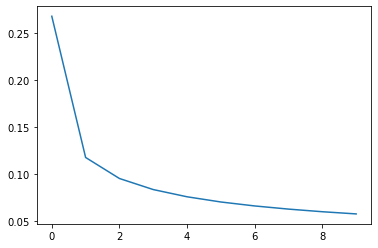

In [75]:
plt.plot(epoch_count, epoch_loss);

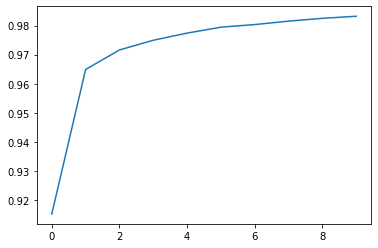

In [76]:
plt.plot(epoch_count, epoch_acc);

## Class Testing Area - using random data to train and test base model

In [9]:
X = np.load("other_data/X.npy")         # Using data found online to train and test the model - non MNIST
y = np.load("other_data/y.npy")

In [10]:
class FC_Layer:     #Relu or Sigmoid activation
    '''A class to represent a fully-connected layer with random initialisation of weights.'''
    def __init__(self, num_inputs, num_neurons):
        self.weights = 0.01 * np.random.randn(num_inputs, num_neurons)                                      # random initialisation of weights with biases set to 0 MAYBE CHANGE 0.01
        print('Weights initialised at mean: %.3f, variance: %.3f, and dimensions: %.0d, %.0d' \
            % (np.mean(self.weights), np.var(self.weights), num_inputs, num_neurons))
        self.biases = np.zeros((1, num_neurons))                                                            

    def forward_pass(self, inputs):
        self.output = np.dot(inputs, self.weights) + self.biases                                            # output of this layer will be inputs*w+b

In [11]:
class ReLU:
   def forward_pass(self, inputs):
      self.output = np.maximum(0, inputs) 

In [12]:
fc_layer = FC_Layer(2,3)                                            # fc_layer with 2 input features and 3 output values

Weights initialised at mean: 0.003, variance: 0.000, and dimensions: 2, 3


In [13]:
activation = ReLU()

In [14]:
fc_layer.forward_pass(X)

In [15]:
activation.forward_pass(fc_layer.output)

In [16]:
print(activation.output[:5])              # output has 5 rows and 3 values each as expected - negative values have been clipped

[[0.00000000e+00 0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.50285430e-04 1.77786582e-05]
 [0.00000000e+00 3.65705285e-04 0.00000000e+00]
 [1.83272261e-04 5.07176229e-04 0.00000000e+00]
 [2.19133263e-04 7.02994079e-04 0.00000000e+00]]


In [17]:
class Softmax:              # meant for classification problems 
   def forward_pass(self, inputs):
       exponents = np.exp(inputs - np.max(inputs, axis=1, keepdims=True))                                     # get unnormalised confidence scores
       confidence_scores = exponents / np.sum(exponents, axis=1, keepdims=True)                               # normalise
       self.output = confidence_scores                              

In [18]:
softmax = Softmax()

In [19]:
softmax.forward_pass([[1, 2, 3]])
print(softmax.output)

[[0.09003057 0.24472847 0.66524096]]


In [20]:
softmax.forward_pass([[-2, -1, 0]])
print(softmax.output)

[[0.09003057 0.24472847 0.66524096]]


In [21]:
fc_layer1 = FC_Layer(2, 3)                          # fc1 with 2 input features and 3 output values
activation1 = ReLU()                                # Relu activation for fc1
fc_layer2 = FC_Layer(3, 3)                          # fc2 with 3 input features and 3 output values
activation2 = Softmax()                             # Softmax activation for fc2
fc_layer1.forward_pass(X)                                # forward pass of our training data through this layer
activation1.forward_pass(fc_layer1.output)             # forward pass through activation function  takes the output of first fc layer
fc_layer2.forward_pass(activation1.output)              # forward pass through fc2 takes outputs of activation function of first fc layer as inputs
activation2.forward_pass(fc_layer2.output)             # forward pass through activation function takes the output of fc2 as inputs
print(activation2.output[:5])

Weights initialised at mean: -0.003, variance: 0.000, and dimensions: 2, 3
Weights initialised at mean: 0.000, variance: 0.000, and dimensions: 3, 3
[[0.33333333 0.33333333 0.33333333]
 [0.33333432 0.3333325  0.33333318]
 [0.33333513 0.33333182 0.33333305]
 [0.33333451 0.33333234 0.33333315]
 [0.3333352  0.33333176 0.33333304]]


In [22]:
class CategoricalCrossEntropyLoss:
    ''' Categorical cross-entropy is explicitly used to compare a 'ground-truth' probability (y) and some predicted distribution (y_pred).'''
    def forward_pass(self, y_pred, y):
        samples = len(y_pred)                                           # Number of samples in a batch
        y_pred_clipped = np.clip(y_pred, 1e-7, 1-1e-7)                  # Prevent division by 0 and prevent dragging mean towards any value
        if len(y.shape) == 1:                                           # Probabilities for target values only if categorical labels
            correct_conf = y_pred_clipped[range(samples), y]
        elif len(y.shape) == 2:
            correct_conf = np.sum(y_pred_clipped*y, axis=1)
        neg_log_likelihoods = -np.log(correct_conf)         
        return neg_log_likelihoods
    
    def loss(self, output, y):                                  # calculates the data and regularisation losses given model output and ground truth values
        sample_losses = self.forward_pass(output, y)            # calculate sample losses
        data_loss = np.mean(sample_losses)                      # calculate mean loss
        return data_loss

In [23]:
fc_layer1 = FC_Layer(2, 3)                              # fc1 with 2 input features and 3 output values
activation1 = ReLU()                                    # Relu activation for fc1
fc_layer2 = FC_Layer(3, 3)                              # fc2 with 3 input features and 3 output values
activation2 = Softmax()                                 # Softmax activation for fc2
loss_func = CategoricalCrossEntropyLoss()
fc_layer1.forward_pass(X)                                # forward pass of our training data through this layer
activation1.forward_pass(fc_layer1.output)             # forward pass through activation function  takes the output of first fc layer
fc_layer2.forward_pass(activation1.output)              # forward pass through fc2 takes outputs of activation function of first fc layer as inputs
activation2.forward_pass(fc_layer2.output)             # forward pass through activation function takes the output of fc2 as inputs
print(activation2.output[:5])
loss = loss_func.loss(activation2.output, y)
print('loss:', loss)

Weights initialised at mean: 0.000, variance: 0.000, and dimensions: 2, 3
Weights initialised at mean: 0.003, variance: 0.000, and dimensions: 3, 3
[[0.33333333 0.33333333 0.33333333]
 [0.33333328 0.33333366 0.33333306]
 [0.33333315 0.33333449 0.33333236]
 [0.33333295 0.3333357  0.33333135]
 [0.33333283 0.33333647 0.3333307 ]]
loss: 1.0986105999068059


In [12]:
class FC_Layer:     #ADDING BACKPROP
    '''A class to represent a fully-connected layer with random initialisation of weights.'''
    def __init__(self, num_inputs, num_neurons):
        self.weights = 0.01 * np.random.randn(num_inputs, num_neurons)                                      # random initialisation of weights with biases set to 0 MAYBE CHANGE 0.01
        print('Weights initialised at mean: %.3f, variance: %.3f, and dimensions: %.0d, %.0d' \
            % (np.mean(self.weights), np.var(self.weights), num_inputs, num_neurons))
        self.biases = np.zeros((1, num_neurons))                                                            

    def forward_pass(self, inputs):
        self.inputs = inputs                                                                                # keep track of inputs for backprop
        self.output = np.dot(inputs, self.weights) + self.biases                                            # output of this layer will be inputs*w+b
    
    def backward_pass(self, tbd):                                                                        # tbd refers to 'To be derived'
        self.deriv_weights = np.dot(self.inputs.T, tbd)                                                  # calculate gradients 
        self.deriv_biases = np.sum(tbd, axis=0, keepdims=True)
        self.deriv_inputs = np.dot(tbd, self.weights.T)

In [13]:
class ReLU:     # ADDING BACKPROP
    def forward_pass(self, inputs):
        self.inputs = inputs
        self.output = np.maximum(0, inputs) 
    
    def backward_pass(self, tbd):
        self.deriv_inputs = tbd.copy()                                                           # keep track of inputs for backprop
        self.deriv_inputs[self.inputs <= 0] = 0                                                          # 0 gradient for negative input values

In [14]:
class Sigmoid:
   def forward(self, inputs):
      self.inputs = inputs
      self.output = 1 / (1 + np.exp(-inputs))
      
   def backward(self, tbd):
      self.deriv_inputs = tbd * (1 - self.output) * self.output

In [15]:
class CategoricalCrossEntropyLoss:         #ADDING BACKPROP
    ''' Categorical cross-entropy is explicitly used to compare a 'ground-truth' probability (y) and some predicted distribution (y_pred).'''
    def forward_pass(self, y_pred, y):
        samples = len(y_pred)                                           # Number of samples in a batch
        y_pred_clipped = np.clip(y_pred, 1e-7, 1-1e-7)                  # Prevent division by 0 and prevent dragging mean towards any value
        if len(y.shape) == 1:                                           # Probabilities for target values only if categorical labels
            correct_conf = y_pred_clipped[range(samples), y]
        elif len(y.shape) == 2:
            correct_conf = np.sum(y_pred_clipped*y, axis=1)
        neg_log_likelihoods = -np.log(correct_conf)         
        return neg_log_likelihoods
    
    def backward_pass(self, tbd, y):                                    # tbd refers to 'To be derived'
        samples = len(tbd)
        labels = len(tbd[0])                                            # number of labels in each sample
        if len(y.shape) == 1:                                           # converted to a list of one-hot encoded vectors if not array   
            y = np.eye(labels)[y]
        self.deriv_inputs = -y / tbd                                    # calculate gradients
        self.deriv_inputs = self.deriv_inputs/samples                   # normalise

    def loss(self, output, y):                                  # calculates the data and regularisation losses given model output and ground truth values
        sample_losses = self.forward_pass(output, y)            # calculate sample losses
        data_loss = np.mean(sample_losses)                      # calculate mean loss
        return data_loss

In [16]:
class Softmax:              #ADDING BACKPROP 
    def forward_pass(self, inputs):
       exponents = np.exp(inputs - np.max(inputs, axis=1, keepdims=True))                                     # get unnormalised confidence scores
       confidence_scores = exponents / np.sum(exponents, axis=1, keepdims=True)                               # normalise
       self.output = confidence_scores 
       self.inputs = inputs

    def backward_pass(self, tbd):
        self.deriv_inputs = np.empty_like(tbd)                                                                # will become the resulting gradient array
        for i, (one_output, one_tbd) in enumerate(zip(self.output, tbd)):                                     # iterating over pairs of outputs and tbds and calculating the derivatives                  
            one_output = one_output.reshape(-1, 1)
            p_deriv_matrix = np.diagflat(one_output) - np.dot(one_output, one_output.T)
            self.deriv_inputs[i] = np.dot(p_deriv_matrix, one_tbd)

In [17]:
class Softmax_Classifier_Loss_CategoricalCrossEntropy(): # combining softmax output classifier and Categorical Cross Entropy loss into one class for faster backprop
    def __init__(self):
        self.activation = Softmax()
        self.loss = CategoricalCrossEntropyLoss()

    def forward_pass(self, inputs, y):
        self.activation.forward_pass(inputs)
        self.output = self.activation.output
        return self.loss.loss(self.output, y)

    def backward_pass(self, tbd, y):
        samples = len(tbd)
        if len(y.shape) == 2:                                                                   # if not one-hot then turn into disrete values
            y = np.argmax(y, axis=1)
        self.deriv_inputs = tbd.copy()
        self.deriv_inputs[range(samples), y] -= 1                                               # calculate gradient and normalise
        self.deriv_inputs = self.deriv_inputs/samples

In [46]:
# TESTING BACKPROP
fc_layer1 = FC_Layer(2, 3)
activation1 = ReLU()
fc_layer2 = FC_Layer(3, 3)
loss_and_activation = Softmax_Classifier_Loss_CategoricalCrossEntropy()

fc_layer1.forward_pass(X)
activation1.forward_pass(fc_layer1.output)
fc_layer2.forward_pass(activation1.output)
loss = loss_and_activation.forward_pass(fc_layer2.output, y)

print(loss_and_activation.output[:5])
print('loss:', loss)
predictions = np.argmax(loss_and_activation.output, axis=1)
if len(y.shape) == 2:
    y = np.argmax(y, axis=1)
accuracy = np.mean(predictions == y)
print('acc:', accuracy)

loss_and_activation.backward_pass(loss_and_activation.output, y)
fc_layer2.backward_pass(loss_and_activation.deriv_inputs)
activation1.backward_pass(fc_layer2.deriv_inputs)
fc_layer1.backward_pass(activation1.deriv_inputs)

print(fc_layer1.deriv_weights)
print(fc_layer1.deriv_biases)
print(fc_layer2.deriv_weights)
print(fc_layer2.deriv_biases)

Weights initialised at mean: -0.001, variance: 0.000, and dimensions: 2, 3
Weights initialised at mean: 0.005, variance: 0.000, and dimensions: 3, 3
[[0.33333333 0.33333333 0.33333333]
 [0.33333332 0.33333333 0.33333335]
 [0.33333288 0.33333315 0.33333396]
 [0.33333154 0.33333266 0.3333358 ]
 [0.33333106 0.33333248 0.33333646]]
loss: 1.0986107183331533
acc: 0.31666666666666665
[[-8.58409420e-06  6.83150294e-05  1.21639315e-04]
 [ 2.48170756e-04 -1.02857426e-04 -5.22625911e-07]]
[[-0.00012621  0.00044465  0.00026259]]
[[-1.83148598e-04  2.78856565e-04 -9.57079672e-05]
 [-5.43075437e-05  2.49428802e-05  2.93646635e-05]
 [-6.15175805e-05  8.19248234e-06  5.33250981e-05]]
[[ 8.12969412e-07 -1.02291297e-05  9.41616032e-06]]


In [18]:
class SGD:
    def __init__(self, lr=1.0):
        self.lr = lr
    
    def update_after_backpass(self, layer):                                             # the layer object contains its parameters (weights and biases) 
        layer.weights += -self.lr * layer.deriv_weights
        layer.biases += -self.lr * layer.deriv_biases

In [59]:
# TESTING SGD and USING EPOCHS for training
fc_layer1 = FC_Layer(2, 64)
activation1 = ReLU()
fc_layer2 = FC_Layer(64, 3)
loss_and_activation = Softmax_Classifier_Loss_CategoricalCrossEntropy()
optimizer = SGD()

for epoch in range(10001):
    fc_layer1.forward_pass(X)
    activation1.forward_pass(fc_layer1.output)
    fc_layer2.forward_pass(activation1.output)
    loss = loss_and_activation.forward_pass(fc_layer2.output, y)

    predictions = np.argmax(loss_and_activation.output, axis=1)
    if len(y.shape) == 2:
        y = np.argmax(y, axis=1)
    accuracy = np.mean(predictions == y)
    if not epoch % 100:
        print(f'epoch: {epoch}, ' + f'acc: {accuracy:.3f}, ' + f'loss: {loss:.3f}')

    loss_and_activation.backward_pass(loss_and_activation.output, y)
    fc_layer2.backward_pass(loss_and_activation.deriv_inputs)
    activation1.backward_pass(fc_layer2.deriv_inputs)
    fc_layer1.backward_pass(activation1.deriv_inputs)
    optimizer.update_after_backpass(fc_layer1)
    optimizer.update_after_backpass(fc_layer2)

Weights initialised at mean: 0.000, variance: 0.000, and dimensions: 2, 64
Weights initialised at mean: 0.000, variance: 0.000, and dimensions: 64, 3
epoch: 0, acc: 0.333, loss: 1.099
epoch: 100, acc: 0.400, loss: 1.093
epoch: 200, acc: 0.410, loss: 1.079
epoch: 300, acc: 0.407, loss: 1.077
epoch: 400, acc: 0.430, loss: 1.076
epoch: 500, acc: 0.413, loss: 1.074
epoch: 600, acc: 0.413, loss: 1.072
epoch: 700, acc: 0.413, loss: 1.069
epoch: 800, acc: 0.423, loss: 1.064
epoch: 900, acc: 0.437, loss: 1.058
epoch: 1000, acc: 0.463, loss: 1.049
epoch: 1100, acc: 0.423, loss: 1.057
epoch: 1200, acc: 0.413, loss: 1.055
epoch: 1300, acc: 0.423, loss: 1.053
epoch: 1400, acc: 0.410, loss: 1.052
epoch: 1500, acc: 0.403, loss: 1.049
epoch: 1600, acc: 0.410, loss: 1.046
epoch: 1700, acc: 0.407, loss: 1.045
epoch: 1800, acc: 0.407, loss: 1.047
epoch: 1900, acc: 0.403, loss: 1.048
epoch: 2000, acc: 0.407, loss: 1.033
epoch: 2100, acc: 0.400, loss: 1.033
epoch: 2200, acc: 0.413, loss: 1.018
epoch: 2300

In [19]:
class SGD: #Updating SGD class to add decay
    def __init__(self, lr=1.0, decay=0.):
        self.lr = lr                                                          # initial learning rate
        self.current_lr = lr
        self.decay = decay
        self.iterations = 0                                                   # no. of iterations the optimiser has gone through
    
    def pre_update(self):
        if self.decay:                                                              # if decay rate is non-0 then update the current learning rate
            self.current_lr = self.lr * (1.0/(1.0 + self.decay*self.iterations))
    
    def update(self, layer):                                             # the layer object contains its parameters (weights and biases) 
        layer.weights += -self.lr * layer.deriv_weights
        layer.biases += -self.lr * layer.deriv_biases

    def post_update(self):
        self.iterations += 1    

In [81]:
# TESTING SGD with decay
fc_layer1 = FC_Layer(2, 64)
activation1 = ReLU()
fc_layer2 = FC_Layer(64, 3)
loss_and_activation = Softmax_Classifier_Loss_CategoricalCrossEntropy()
optimiser = SGD(decay=0.001)
num_iterations = 100001
for epoch in range(num_iterations):
    fc_layer1.forward_pass(X)
    activation1.forward_pass(fc_layer1.output)
    fc_layer2.forward_pass(activation1.output)
    loss = loss_and_activation.forward_pass(fc_layer2.output, y)

    predictions = np.argmax(loss_and_activation.output, axis=1)
    if len(y.shape) == 2:
        y = np.argmax(y, axis=1)
    accuracy = np.mean(predictions == y)
    if not epoch % 100:
        print(f'epoch: {epoch}, ' + f'acc: {accuracy:.3f}, ' + f'loss: {loss:.3f} ' \
        + f'lr: {optimiser.current_lr} ')

    loss_and_activation.backward_pass(loss_and_activation.output, y)
    fc_layer2.backward_pass(loss_and_activation.deriv_inputs)
    activation1.backward_pass(fc_layer2.deriv_inputs)
    fc_layer1.backward_pass(activation1.deriv_inputs)
    optimiser.pre_update()
    optimiser.update_after_backpass(fc_layer1)
    optimiser.update_after_backpass(fc_layer2)
    optimiser.post_update()

Weights initialised at mean: 0.002, variance: 0.000, and dimensions: 2, 64
Weights initialised at mean: -0.001, variance: 0.000, and dimensions: 64, 3
epoch: 0, acc: 0.383, loss: 1.099 lr: 1.0 
epoch: 100, acc: 0.407, loss: 1.088 lr: 0.9099181073703367 
epoch: 200, acc: 0.430, loss: 1.078 lr: 0.8340283569641367 
epoch: 300, acc: 0.430, loss: 1.076 lr: 0.7698229407236336 
epoch: 400, acc: 0.407, loss: 1.073 lr: 0.7147962830593281 
epoch: 500, acc: 0.410, loss: 1.069 lr: 0.66711140760507 
epoch: 600, acc: 0.413, loss: 1.063 lr: 0.6253908692933083 
epoch: 700, acc: 0.423, loss: 1.055 lr: 0.5885815185403178 
epoch: 800, acc: 0.410, loss: 1.060 lr: 0.5558643690939411 
epoch: 900, acc: 0.400, loss: 1.054 lr: 0.526592943654555 
epoch: 1000, acc: 0.410, loss: 1.052 lr: 0.5002501250625312 
epoch: 1100, acc: 0.410, loss: 1.050 lr: 0.4764173415912339 
epoch: 1200, acc: 0.413, loss: 1.047 lr: 0.45475216007276037 
epoch: 1300, acc: 0.427, loss: 1.060 lr: 0.43497172683775553 
epoch: 1400, acc: 0.403

In [20]:
class SGD: #Updating SGD class to add momentum
    def __init__(self, lr=1.0, decay=0.0, momentum=0.0):
        self.lr = lr                                                                    # initial learning rate
        self.current_lr = lr
        self.decay = decay
        self.momentum = momentum
        self.iterations = 0                                                             # no. of iterations the optimiser has gone through
    
    def pre_update(self):
        if self.decay:                                                                  # if decay rate is non-0 then update the current learning rate
            self.current_lr = self.lr * (1.0/(1.0 + self.decay*self.iterations))
    
    def update(self, layer):                                                            # the layer object contains its parameters (weights and biases) 
        if self.momentum:
            if not hasattr(layer, 'w_momentums'):                                                   # If layer does not contain momentum arrays, create them filled with zeros
                layer.w_momentums = np.zeros_like(layer.weights)
                layer.b_momentums = np.zeros_like(layer.biases)
            w_updates = self.momentum * layer.w_momentums - self.current_lr * layer.deriv_weights   # Build weight updates with momentum - take previous updates multiplied by retain factor and update with current gradients
            layer.w_momentums = w_updates
            b_updates = self.momentum * layer.b_momentums - self.current_lr * layer.deriv_biases
            layer.b_momentums = b_updates
        else:
            w_updates = -self.current_lr * layer.deriv_weights                                  # do normal SGD
            b_updates = -self.current_lr * layer.deriv_biases
        layer.weights += w_updates
        layer.biases += b_updates

    def post_update(self):
        self.iterations += 1    

In [99]:
# TESTING SGD with momentum
fc_layer1 = FC_Layer(2, 64)
activation1 = ReLU()
fc_layer2 = FC_Layer(64, 3)
loss_and_activation = Softmax_Classifier_Loss_CategoricalCrossEntropy()
optimiser = SGD(decay=0.001, momentum=0.9)
num_iterations = 10001
for epoch in range(num_iterations):
    fc_layer1.forward_pass(X)
    activation1.forward_pass(fc_layer1.output)
    fc_layer2.forward_pass(activation1.output)
    loss = loss_and_activation.forward_pass(fc_layer2.output, y)

    predictions = np.argmax(loss_and_activation.output, axis=1)
    if len(y.shape) == 2:
        y = np.argmax(y, axis=1)
    accuracy = np.mean(predictions == y)
    if not epoch % 100:
        print(f'epoch: {epoch}, ' + f'acc: {accuracy:.3f}, ' + f'loss: {loss:.3f} ' \
        + f'lr: {optimiser.current_lr} ')

    loss_and_activation.backward_pass(loss_and_activation.output, y)
    fc_layer2.backward_pass(loss_and_activation.deriv_inputs)
    activation1.backward_pass(fc_layer2.deriv_inputs)
    fc_layer1.backward_pass(activation1.deriv_inputs)
    optimiser.pre_update()
    optimiser.update(fc_layer1)
    optimiser.update(fc_layer2)
    optimiser.post_update()

Weights initialised at mean: -0.001, variance: 0.000, and dimensions: 2, 64
Weights initialised at mean: 0.001, variance: 0.000, and dimensions: 64, 3
epoch: 0, acc: 0.337, loss: 1.099 lr: 1.0 
epoch: 100, acc: 0.437, loss: 1.067 lr: 0.9099181073703367 
epoch: 200, acc: 0.440, loss: 1.016 lr: 0.8340283569641367 
epoch: 300, acc: 0.610, loss: 0.815 lr: 0.7698229407236336 
epoch: 400, acc: 0.710, loss: 0.659 lr: 0.7147962830593281 
epoch: 500, acc: 0.807, loss: 0.585 lr: 0.66711140760507 
epoch: 600, acc: 0.830, loss: 0.435 lr: 0.6253908692933083 
epoch: 700, acc: 0.840, loss: 0.386 lr: 0.5885815185403178 
epoch: 800, acc: 0.840, loss: 0.367 lr: 0.5558643690939411 
epoch: 900, acc: 0.887, loss: 0.307 lr: 0.526592943654555 
epoch: 1000, acc: 0.840, loss: 0.375 lr: 0.5002501250625312 
epoch: 1100, acc: 0.867, loss: 0.330 lr: 0.4764173415912339 
epoch: 1200, acc: 0.870, loss: 0.314 lr: 0.45475216007276037 
epoch: 1300, acc: 0.870, loss: 0.305 lr: 0.43497172683775553 
epoch: 1400, acc: 0.870

In [21]:
class Adam:
    def __init__(self, lr=0.001, decay=0.0, epsilon=0.0000001, beta1=0.9, beta2=0.999):
        self.lr = lr
        self.current_lr = lr
        self.decay = decay
        self.iterations = 0
        self.epsilon = epsilon
        self.beta1 = beta1
        self.beta2 = beta2

    def pre_update(self):
        if self.decay:
            self.current_lr = self.lr * (1. / (1. + self.decay * self.iterations))

    def update(self, layer):                                                                                    
        if not hasattr(layer, 'w_cache'):                                                                                # if layer does not contain cache then fill with zeros
            layer.w_momentums = np.zeros_like(layer.weights)
            layer.w_cache = np.zeros_like(layer.weights)
            layer.b_momentums = np.zeros_like(layer.biases)
            layer.b_cache = np.zeros_like(layer.biases)
        layer.w_momentums = self.beta1 * layer.w_momentums + (1 - self.beta1) * layer.deriv_weights                     # update momentum using derivatives
        layer.b_momentums = self.beta1 * layer.b_momentums + (1 - self.beta1) * layer.deriv_biases
        w_momentums_corrected = layer.w_momentums /(1-self.beta1 ** (self.iterations + 1))                              # iteration is 0 at first and we need to start with 1 so we correct
        b_momentums_corrected = layer.b_momentums /(1-self.beta1 ** (self.iterations + 1))
        layer.w_cache = self.beta2 * layer.w_cache + (1 - self.beta2) * layer.deriv_weights**2
        layer.b_cache = self.beta2 * layer.b_cache + (1 - self.beta2) * layer.deriv_biases**2
        w_cache_corrected = layer.w_cache / (1-self.beta2 ** (self.iterations + 1))                                     # correct cache too
        b_cache_corrected = layer.b_cache / (1-self.beta2 ** (self.iterations + 1))
        layer.weights += -self.current_lr * w_momentums_corrected / (np.sqrt(w_cache_corrected) + self.epsilon)           # do SGD
        layer.biases += -self.current_lr * b_momentums_corrected / (np.sqrt(b_cache_corrected) + self.epsilon)

    def post_update(self):
        self.iterations += 1

In [107]:
# TESTING Adam
fc_layer1 = FC_Layer(2, 64)
activation1 = ReLU()
fc_layer2 = FC_Layer(64, 3)
loss_and_activation = Softmax_Classifier_Loss_CategoricalCrossEntropy()
optimiser = Adam(lr=0.02, decay=0.00001)
num_iterations = 10001
for epoch in range(num_iterations):
    fc_layer1.forward_pass(X)
    activation1.forward_pass(fc_layer1.output)
    fc_layer2.forward_pass(activation1.output)
    loss = loss_and_activation.forward_pass(fc_layer2.output, y)

    predictions = np.argmax(loss_and_activation.output, axis=1)
    if len(y.shape) == 2:
        y = np.argmax(y, axis=1)
    accuracy = np.mean(predictions == y)
    if not epoch % 100:
        print(f'epoch: {epoch}, ' + f'acc: {accuracy:.3f}, ' + f'loss: {loss:.3f} ' \
        + f'lr: {optimiser.current_lr} ')

    loss_and_activation.backward_pass(loss_and_activation.output, y)
    fc_layer2.backward_pass(loss_and_activation.deriv_inputs)
    activation1.backward_pass(fc_layer2.deriv_inputs)
    fc_layer1.backward_pass(activation1.deriv_inputs)
    optimiser.pre_update()
    optimiser.update(fc_layer1)
    optimiser.update(fc_layer2)
    optimiser.post_update()

Weights initialised at mean: -0.001, variance: 0.000, and dimensions: 2, 64
Weights initialised at mean: 0.000, variance: 0.000, and dimensions: 64, 3
epoch: 0, acc: 0.343, loss: 1.099 lr: 0.02 
epoch: 100, acc: 0.667, loss: 0.848 lr: 0.01998021958261321 
epoch: 200, acc: 0.710, loss: 0.670 lr: 0.019960279044701046 
epoch: 300, acc: 0.790, loss: 0.548 lr: 0.019940378268975763 
epoch: 400, acc: 0.820, loss: 0.479 lr: 0.01992051713662487 
epoch: 500, acc: 0.847, loss: 0.425 lr: 0.01990069552930875 
epoch: 600, acc: 0.863, loss: 0.396 lr: 0.019880913329158343 
epoch: 700, acc: 0.867, loss: 0.370 lr: 0.019861170418772778 
epoch: 800, acc: 0.860, loss: 0.351 lr: 0.019841466681217078 
epoch: 900, acc: 0.883, loss: 0.330 lr: 0.01982180200001982 
epoch: 1000, acc: 0.890, loss: 0.309 lr: 0.019802176259170884 
epoch: 1100, acc: 0.897, loss: 0.294 lr: 0.01978258934311912 
epoch: 1200, acc: 0.900, loss: 0.281 lr: 0.01976304113677013 
epoch: 1300, acc: 0.900, loss: 0.270 lr: 0.019743531525483964 
e

In [22]:
# TESTING Adam Part 2
fc_layer1 = FC_Layer(2, 64)
activation1 = ReLU()
fc_layer2 = FC_Layer(64, 3)
loss_and_activation = Softmax_Classifier_Loss_CategoricalCrossEntropy()
optimiser = Adam(lr=0.05, decay=0.0000005)
num_iterations = 10001
accuracy_train = []
loss_train = []
epoch_count = []
for epoch in range(num_iterations):
    fc_layer1.forward_pass(X)
    activation1.forward_pass(fc_layer1.output)
    fc_layer2.forward_pass(activation1.output)
    loss = loss_and_activation.forward_pass(fc_layer2.output, y)
    loss_train.append(loss)
    predictions = np.argmax(loss_and_activation.output, axis=1)
    if len(y.shape) == 2:
        y = np.argmax(y, axis=1)
    accuracy = np.mean(predictions == y)
    accuracy_train.append(accuracy)
    if not epoch % 100:
        print(f'epoch: {epoch}, ' + f'acc: {accuracy:.3f}, ' + f'loss: {loss:.3f} ' \
        + f'lr: {optimiser.current_lr} ')

    loss_and_activation.backward_pass(loss_and_activation.output, y)
    fc_layer2.backward_pass(loss_and_activation.deriv_inputs)
    activation1.backward_pass(fc_layer2.deriv_inputs)
    fc_layer1.backward_pass(activation1.deriv_inputs)
    optimiser.pre_update()
    optimiser.update(fc_layer1)
    optimiser.update(fc_layer2)
    optimiser.post_update()
    epoch_count.append(epoch)

Weights initialised at mean: 0.001, variance: 0.000, and dimensions: 2, 64
Weights initialised at mean: 0.000, variance: 0.000, and dimensions: 64, 3
epoch: 0, acc: 0.290, loss: 1.099 lr: 0.05 
epoch: 100, acc: 0.677, loss: 0.653 lr: 0.04999752512250644 
epoch: 200, acc: 0.797, loss: 0.529 lr: 0.04999502549496326 
epoch: 300, acc: 0.823, loss: 0.444 lr: 0.049992526117345455 
epoch: 400, acc: 0.880, loss: 0.364 lr: 0.04999002698961558 
epoch: 500, acc: 0.897, loss: 0.313 lr: 0.049987528111736124 
epoch: 600, acc: 0.913, loss: 0.278 lr: 0.049985029483669646 
epoch: 700, acc: 0.907, loss: 0.251 lr: 0.049982531105378675 
epoch: 800, acc: 0.913, loss: 0.231 lr: 0.04998003297682575 
epoch: 900, acc: 0.920, loss: 0.217 lr: 0.049977535097973466 
epoch: 1000, acc: 0.923, loss: 0.205 lr: 0.049975037468784345 
epoch: 1100, acc: 0.923, loss: 0.196 lr: 0.049972540089220974 
epoch: 1200, acc: 0.910, loss: 0.198 lr: 0.04997004295924593 
epoch: 1300, acc: 0.930, loss: 0.185 lr: 0.04996754607882181 
ep

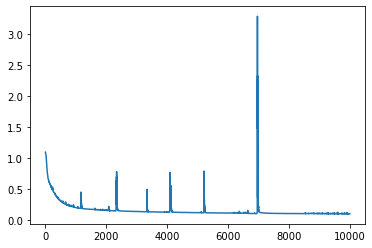

In [23]:
plt.plot(epoch_count, loss_train);

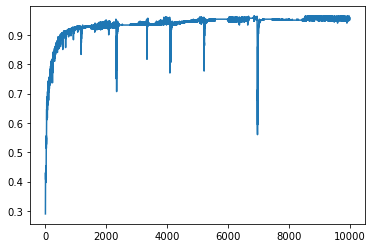

In [24]:
plt.plot(epoch_count, accuracy_train);

In [23]:
X_test = np.load("other_data/X_test.npy")         # Testing classes with data from the same function as used for training
y_test = np.load("other_data/y_test.npy")

In [25]:
# Using Validation data
fc_layer1 = FC_Layer(2, 64)
activation1 = ReLU()
fc_layer2 = FC_Layer(64, 3)
loss_and_activation = Softmax_Classifier_Loss_CategoricalCrossEntropy()
optimiser = Adam(lr=0.05, decay=0.0000005)
num_iterations = 10001
accuracy_train = []
loss_train = []
epoch_count = []
for epoch in range(num_iterations):
    fc_layer1.forward_pass(X_test)
    activation1.forward_pass(fc_layer1.output)
    fc_layer2.forward_pass(activation1.output)
    loss = loss_and_activation.forward_pass(fc_layer2.output, y_test)

    predictions = np.argmax(loss_and_activation.output, axis=1)
    if len(y_test.shape) == 2:
        y_test = np.argmax(y_test, axis=1)
    accuracy = np.mean(predictions == y_test)
    if not epoch % 100:
        print(f'validation, acc: {accuracy:.3f}, loss: {loss:.3f}')

    loss_and_activation.backward_pass(loss_and_activation.output, y)
    fc_layer2.backward_pass(loss_and_activation.deriv_inputs)
    activation1.backward_pass(fc_layer2.deriv_inputs)
    fc_layer1.backward_pass(activation1.deriv_inputs)
    optimiser.pre_update()
    optimiser.update(fc_layer1)
    optimiser.update(fc_layer2)
    optimiser.post_update()
    epoch_count.append(epoch)

Weights initialised at mean: -0.001, variance: 0.000, and dimensions: 2, 64
Weights initialised at mean: 0.000, variance: 0.000, and dimensions: 64, 3
validation, acc: 0.277, loss: 1.099
validation, acc: 0.780, loss: 0.624
validation, acc: 0.820, loss: 0.449
validation, acc: 0.850, loss: 0.367
validation, acc: 0.877, loss: 0.312
validation, acc: 0.897, loss: 0.282
validation, acc: 0.910, loss: 0.263
validation, acc: 0.920, loss: 0.245
validation, acc: 0.920, loss: 0.230
validation, acc: 0.917, loss: 0.216
validation, acc: 0.937, loss: 0.204
validation, acc: 0.937, loss: 0.194
validation, acc: 0.923, loss: 0.199
validation, acc: 0.933, loss: 0.189
validation, acc: 0.937, loss: 0.185
validation, acc: 0.940, loss: 0.181
validation, acc: 0.940, loss: 0.178
validation, acc: 0.940, loss: 0.176
validation, acc: 0.943, loss: 0.172
validation, acc: 0.950, loss: 0.169
validation, acc: 0.950, loss: 0.166
validation, acc: 0.953, loss: 0.164
validation, acc: 0.957, loss: 0.161
validation, acc: 0.94